In [1]:
HOST = '37.139.42.145'
DBNAME = 'game-analytics'
USER = 'analytics'
PASSWORD = *****************
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine(f'postgresql://{USER}:{PASSWORD}@{HOST}/{DBNAME}')
TABLE_SCHEMA ='data_viz_1068.project_dataset'

1. Разбить всех пользователей по трём типам в зависимости от даты первого входа:

-новые игроки (дата первого входа в текущем месяце),

-старые игроки (дата первого входа в прошлом месяце),

-очень старые игроки (дата первого входа более чем 2 месяца назад).

Для простоты исследования взять только 1 месяц — январь 2021 года. Если возьмёте все доступные месяцы и посчитает в каждом отдельно, будет считаться как выполнение задания повышенной сложности.


In [2]:
pd.read_sql(f'''
with data as
(SELECT distinct user_id,  DATE_PART('month',AGE(date_now,date_install)) as life, to_char(date_now,'YYYY-MM') as month_now
FROM
(SELECT user_id, 
min(date_trunc('month',event_date)::date) filter (where event_name='FirstLaunchApp') OVER (PARTITION BY user_id) as date_install,
date_trunc('month',event_date)::date as date_now
FROM data_viz_1068.project_dataset) as a)

SELECT month_now,user_id, 
case WHEN (life =0) then 'new_users'
WHEN (life=1) then 'users'
else 'old_users' end as users_type
FROM data
''', con=engine)

,month_now,user_id,users_type
0,2020-11,100002,old_users
1,2021-01,100003,new_users
2,2021-02,100003,users
3,2021-03,100003,old_users
4,2020-12,100006,old_users
...,...,...,...
79491,2021-05,232719,new_users
79492,2021-05,232720,new_users
79493,2021-05,232722,new_users
79494,2021-05,232723,new_users


2. Определить процент платящих от месячной аудитории по когортам: iOS/Android в регионах NA и CIS (4 когорты) в каждой когорте из пунтка 1.

In [3]:
pd.read_sql(f'''
with data as
(SELECT distinct user_id,  DATE_PART('month',AGE(date_now,date_install)) as life, to_char(date_now,'YYYY-MM') as month_now,
platform, region,event_name
FROM
(SELECT user_id, platform,event_name, 
case WHEN country in ('RU', 'AZ', 'AM', 'BY','KZ', 'KG','MD', 'TJ', 'UZ', 'UA', 'TM') then 'CIS'
WHEN country in ('CA', 'US') then 'NA'
             else 'Other' end as region,
min(date_trunc('month',event_date)::date) filter (where event_name='FirstLaunchApp') OVER (PARTITION BY user_id) as date_install,
date_trunc('month',event_date)::date as date_now
FROM data_viz_1068.project_dataset
)  as a
WHERE region in ('NA','CIS'))

SELECT month_now,
(cast((count(distinct user_id) filter (where event_name='af_purchase')) as float)/cast((count(distinct user_id)) as float))*100 as payers,
 platform, region,
case WHEN (life =0) then '1_new_users'
WHEN (life=1) then '2_users'
else '3_old_users' end as users_type
FROM data
GROUP BY month_now, platform, region, users_type
''', con=engine)

,month_now,payers,platform,region,users_type
0,2020-10,33.333333,android,CIS,1_new_users
1,2020-10,2.129925,ios,CIS,1_new_users
2,2020-10,2.005013,ios,CIS,3_old_users
3,2020-10,3.164557,ios,NA,1_new_users
4,2020-10,5.179283,ios,NA,3_old_users
...,...,...,...,...,...
84,2021-05,2.500000,ios,CIS,2_users
85,2021-05,2.795031,ios,CIS,3_old_users
86,2021-05,7.024793,ios,NA,1_new_users
87,2021-05,13.333333,ios,NA,2_users


3. Сравнить процент платящих в каждой из исследуемых когорт, сделать выводы.

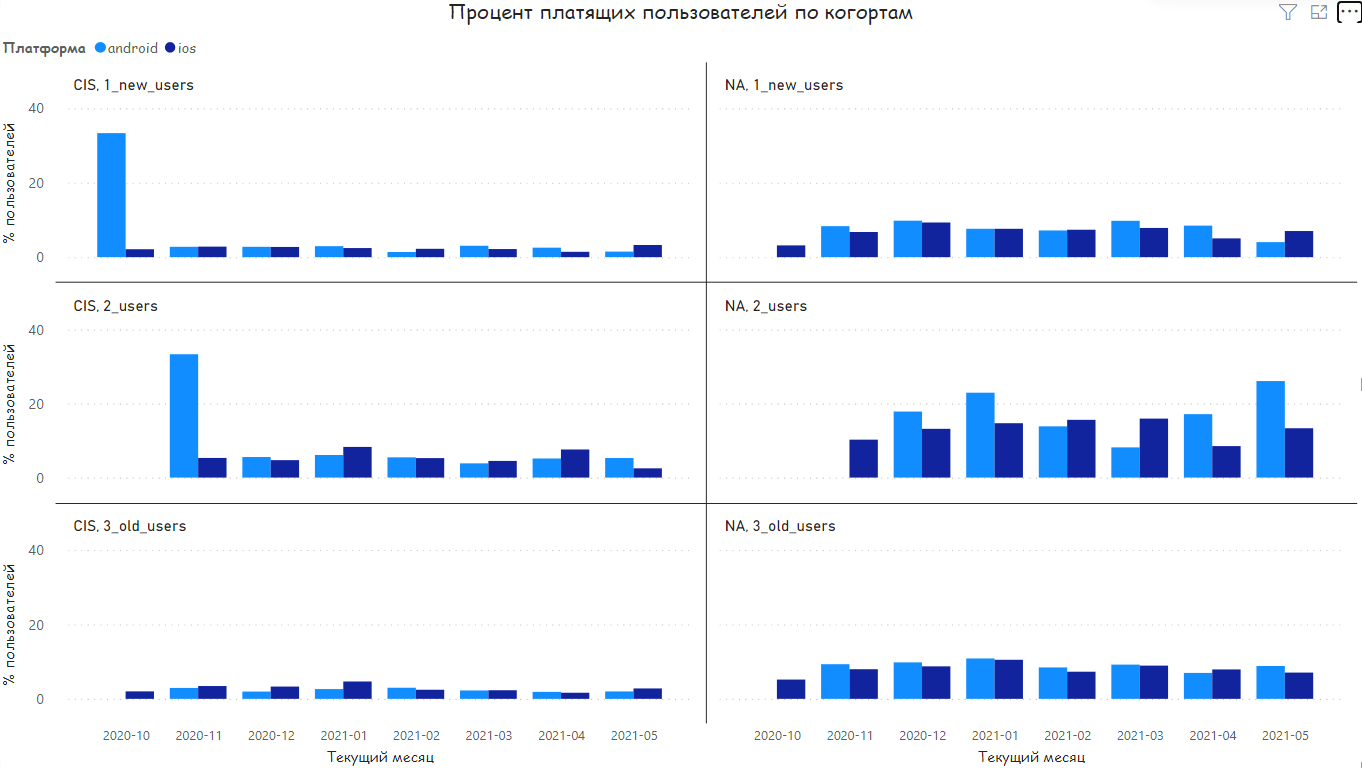

Вывод: Рассматривая график, можно сделать вывод, что наибольший процент платящих пользователей из активной аудитории приходится на пользователей, чей срок нахождения в игре варьируется в пределах от 1го до 2ух месяцев (в обоих регионах и платформах). Говоря о самых старых пользователях, процент платящих чуть больше, чем у новых. Сравнивая регионы, процент платящих у Северной Америки больше во всех когортах. Сравнивая процент платящих пользователей по платформам, можно сделать вывод, что все типы пользователей, во всех регионах имеют примерно одинаковые показатели, но в Северной Америке преобладает андроид. 

4. Ответить на вопрос: «‎Почему у более старых игроков процент платящих отличается от более новых?».


Ответ: Чем больше пользователь играет, тем выше его потребительская лояльность, что приводит к совершению платежей. Говоря о пользователях, которые провели в игре более 2-х месяцев, то, возможно, процент платящих снижается, так как все самое необходимое игрок уже закупил ранее. В первый месяц игрок пробует игру, узнает ее и если она ему понравилась, то он хочет достигать новых целей, которые иногда нельзя добиться без покупки какого либо предмета в магазине. Также, не стоит забывать о людях, которые любят выделятся - им важно постоянно приобретатать новые визуальные элементы, чтобы их образ отличен от других.